In [1]:
!pip install catboost mlflow dagshub optuna

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    MinMaxScaler
)

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor
)

from sklearn.pipeline import Pipeline

In [4]:
import mlflow
import dagshub

In [5]:
dagshub.init(repo_owner='Aryanupadhyay23', repo_name='Zomato-Food-Delivery-Time-prediction', mlflow=True)

Accessing as Aryanupadhyay23

Initialized MLflow to track repo "Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction"

Repository Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction initialized!

In [6]:
# set the tracking uri

mlflow.set_tracking_uri("https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow")

In [7]:
df = pd.read_csv("zomato_cleaned.csv")

In [8]:
df.head()

,rider_id,rider_age,rider_ratings,restaurant_lat,restaurant_long,location_lat,location_long,order_date,weather,traffic_density,...,city_name,city_type,order_day,order_month,day_name,is_weekend,time_of_day,order_hour,distance,distance_bin
0,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,fog,jam,...,dehradun,metropolitian,12,2,saturday,1,dinner_peak,21,10.280582,long
1,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,stormy,high,...,kochi,metropolitian,13,2,sunday,1,afternoon,14,6.242319,medium
2,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,sandstorms,medium,...,pune,metropolitian,4,3,friday,0,evening_snacks,17,13.787860,long
3,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,sandstorms,low,...,ludhiana,metropolitian,13,2,sunday,1,breakfast,9,2.930258,short
4,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,fog,jam,...,kanpur,metropolitian,14,2,monday,0,evening_snacks,19,19.396618,very_long


In [9]:
df.columns

Index(['rider_id', 'rider_age', 'rider_ratings', 'restaurant_lat',
       'restaurant_long', 'location_lat', 'location_long', 'order_date',
       'weather', 'traffic_density', 'vehicle_condition', 'order_type',
       'vehicle_type', 'multiple_deliveries', 'festival', 'time_taken',
       'city_name', 'city_type', 'order_day', 'order_month', 'day_name',
       'is_weekend', 'time_of_day', 'order_hour', 'distance', 'distance_bin'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43585 entries, 0 to 43584
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rider_id             43585 non-null  object 
 1   rider_age            43585 non-null  float64
 2   rider_ratings        43585 non-null  float64
 3   restaurant_lat       40100 non-null  float64
 4   restaurant_long      40100 non-null  float64
 5   location_lat         40100 non-null  float64
 6   location_long        40100 non-null  float64
 7   order_date           43585 non-null  object 
 8   weather              43585 non-null  object 
 9   traffic_density      43585 non-null  object 
 10  vehicle_condition    43585 non-null  int64  
 11  order_type           43585 non-null  object 
 12  vehicle_type         43585 non-null  object 
 13  multiple_deliveries  42652 non-null  float64
 14  festival             43368 non-null  object 
 15  time_taken           43585 non-null 

In [11]:
df['order_day'].head()

,order_day
0,12
1,13
2,4
3,13
4,14


In [12]:
columns_to_drop = [
    'rider_id',
    'restaurant_lat',
    'restaurant_long',
    'location_lat',
    'location_long',
    'order_date',
    'order_hour',
    'order_day',
    'distance_bin',
    'city_name',
    'is_weekend',
    'order_month'
]

df = df.drop(columns=columns_to_drop)
df.head()

,rider_age,rider_ratings,weather,traffic_density,vehicle_condition,order_type,vehicle_type,multiple_deliveries,festival,time_taken,city_type,day_name,time_of_day,distance
0,36.0,4.2,fog,jam,2,snack,motorcycle,3.0,no,46,metropolitian,saturday,dinner_peak,10.280582
1,21.0,4.7,stormy,high,1,meal,motorcycle,1.0,no,23,metropolitian,sunday,afternoon,6.242319
2,23.0,4.7,sandstorms,medium,1,drinks,scooter,1.0,no,21,metropolitian,friday,evening_snacks,13.787860
3,34.0,4.3,sandstorms,low,0,buffet,motorcycle,0.0,no,20,metropolitian,sunday,breakfast,2.930258
4,24.0,4.7,fog,jam,1,snack,scooter,1.0,no,41,metropolitian,monday,evening_snacks,19.396618


In [13]:
df.isna().sum()

,0
rider_age,0
rider_ratings,0
weather,0
traffic_density,0
vehicle_condition,0
order_type,0
vehicle_type,0
multiple_deliveries,933
festival,217
time_taken,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43585 entries, 0 to 43584
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rider_age            43585 non-null  float64
 1   rider_ratings        43585 non-null  float64
 2   weather              43585 non-null  object 
 3   traffic_density      43585 non-null  object 
 4   vehicle_condition    43585 non-null  int64  
 5   order_type           43585 non-null  object 
 6   vehicle_type         43585 non-null  object 
 7   multiple_deliveries  42652 non-null  float64
 8   festival             43368 non-null  object 
 9   time_taken           43585 non-null  int64  
 10  city_type            42450 non-null  object 
 11  day_name             43585 non-null  object 
 12  time_of_day          43585 non-null  object 
 13  distance             40100 non-null  float64
dtypes: float64(4), int64(2), object(8)
memory usage: 4.7+ MB


In [15]:
df.dropna(inplace=True)

In [16]:
df.to_csv(
    "food_delivery_interim.csv",
    index=False
)

In [17]:
X = df.drop(columns='time_taken')
y = df['time_taken']

In [18]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [19]:
X_train.shape

(30444, 13)

In [20]:
X_train.isna().sum()

,0
rider_age,0
rider_ratings,0
weather,0
traffic_density,0
vehicle_condition,0
order_type,0
vehicle_type,0
multiple_deliveries,0
festival,0
city_type,0


In [21]:
num_cols = ["rider_age","rider_ratings","distance"]

nominal_cat_cols = ["weather","order_type","vehicle_type","festival","city_type","day_name","time_of_day"]

ordinal_cat_cols = ["traffic_density"]

In [22]:
traffic_order = ["low","medium","high","jam"]

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), num_cols),
        (
            "nominal_encoder",
            OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False),
            nominal_cat_cols
        ),
        (
            "ordinal_encoder",
            OrdinalEncoder(categories=[traffic_order]),
            ordinal_cat_cols
        )
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

preprocessor.set_output(transform="pandas")


ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['rider_age', 'rider_ratings', 'distance']),
                                ('nominal_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'order_type', 'vehicle_type',
                                  'festival', 'city_type', 'day_name',
                                  'time_of_day']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam']]),
                                 ['traffic_density'])],
                  verbose_feature_names_out=False)

In [24]:
pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [25]:
y_train_pt = np.ravel(y_train_pt)
y_test_pt  = np.ravel(y_test_pt)

In [26]:
## pipeline

preprocessing_pipeline = Pipeline(
    steps=[
        ("preprocessor",preprocessor)
    ]
)

preprocessing_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['rider_age', 'rider_ratings',
                                                   'distance']),
                                                 ('nominal_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'order_type',
                                                   'vehicle_type', 'festival',
                                                   'city_type', 'day_name',
                                                   'time_of_day']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam']]),
                                                  ['traffic_density'])],
                                   verbose_feature_names_out=False))])

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30444 entries, 7997 to 18056
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rider_age            30444 non-null  float64
 1   rider_ratings        30444 non-null  float64
 2   weather              30444 non-null  object 
 3   traffic_density      30444 non-null  object 
 4   vehicle_condition    30444 non-null  int64  
 5   order_type           30444 non-null  object 
 6   vehicle_type         30444 non-null  object 
 7   multiple_deliveries  30444 non-null  float64
 8   festival             30444 non-null  object 
 9   city_type            30444 non-null  object 
 10  day_name             30444 non-null  object 
 11  time_of_day          30444 non-null  object 
 12  distance             30444 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 3.3+ MB


In [28]:
X_train_trans = preprocessing_pipeline.fit_transform(X_train)
X_test_trans = preprocessing_pipeline.transform(X_test)

X_train_trans

,rider_age,rider_ratings,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,order_type_drinks,order_type_meal,...,day_name_tuesday,day_name_wednesday,time_of_day_breakfast,time_of_day_dinner_peak,time_of_day_evening_snacks,time_of_day_late_night,time_of_day_lunch_peak,traffic_density,vehicle_condition,multiple_deliveries
7997,-0.282097,1.164633,-1.211247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,0.0
16083,1.454428,0.849370,0.717574,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0,3.0
29424,-0.455749,0.218843,0.144911,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2,1.0
40177,1.280776,-1.988001,-0.385292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2,1.0
6821,0.759818,-0.726947,0.689886,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19246,-1.671317,1.164633,-1.203960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
7206,-0.976707,-1.672737,-0.932219,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
12930,-0.976707,-1.672737,0.653365,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0,1.0
994,1.454428,-1.357474,0.757606,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2,2.0


## model selection

In [30]:
import optuna
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_validate

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [31]:
def objective(trial):

    model_name = trial.suggest_categorical(
        "model",
        [
            "Linear Regression",
            "Decision Tree",
            "Random Forest",
            "Gradient Boosting",
            "SVR",
            "XGBoost",
            "LightGBM",
            "CatBoost"
        ]
    )

    # ---------------- LINEAR ----------------
    if model_name == "Linear Regression":
        model = LinearRegression()

    # ---------------- TREE ----------------
    elif model_name == "Decision Tree":
        model = DecisionTreeRegressor(
            max_depth=trial.suggest_int("dt_max_depth", 5, 20),
            min_samples_leaf=trial.suggest_int("dt_min_samples_leaf", 5, 20),
            random_state=42
        )

    elif model_name == "Random Forest":
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 500),
            max_depth=trial.suggest_int("rf_max_depth", 8, 20),
            min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 3, 10),
            random_state=42,
            n_jobs=-1
        )

    elif model_name == "Gradient Boosting":
        model = GradientBoostingRegressor(
            n_estimators=trial.suggest_int("gb_n_estimators", 50, 500),
            learning_rate=trial.suggest_float(
                "gb_learning_rate", 0.01, 0.1, log=True
            ),
            max_depth=trial.suggest_int("gb_max_depth", 3, 6),
            random_state=42
        )

    # ---------------- KERNEL ----------------
    elif model_name == "SVR":
      model = SVR(
        kernel="rbf",
        C=trial.suggest_float("svr_C", 1.0, 10.0, log=True),
        epsilon=trial.suggest_float("svr_epsilon", 0.01, 0.3),
        gamma=trial.suggest_float("svr_gamma", 1e-4, 1e-1, log=True)
    )



    # ---------------- BOOSTING ----------------
    elif model_name == "XGBoost":
        model = XGBRegressor(
            tree_method="hist",
            n_estimators=trial.suggest_int("xgb_n_estimators", 50, 500),
            learning_rate=trial.suggest_float(
                "xgb_learning_rate", 0.01, 0.1, log=True
            ),
            max_depth=trial.suggest_int("xgb_max_depth", 4, 8),
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )

    elif model_name == "LightGBM":
        model = LGBMRegressor(
            n_estimators=trial.suggest_int("lgb_n_estimators", 50, 500),
            learning_rate=trial.suggest_float(
                "lgb_learning_rate", 0.01, 0.1, log=True
            ),
            num_leaves=trial.suggest_int("lgb_num_leaves", 20, 80),
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )

    else:
        model = CatBoostRegressor(
            iterations=trial.suggest_int("cat_iterations", 50, 500),
            learning_rate=trial.suggest_float(
                "cat_learning_rate", 0.01, 0.1, log=True
            ),
            depth=trial.suggest_int("cat_depth", 4, 8),
            loss_function="RMSE",
            random_seed=42,
            verbose=0
        )

    # -------- TRAIN & EVALUATE --------
    model.fit(X_train_trans, y_train_pt)
    preds = model.predict(X_test_trans)

    return mean_absolute_error(y_test_pt, preds)

In [32]:
def print_progress(study, trial):
    print(
        f"Trial {trial.number} | "
        f"Model: {trial.params.get('model')} | "
        f"MAE: {trial.value:.4f} | "
        f"Best MAE: {study.best_value:.4f}"
    )

In [33]:
study = optuna.create_study(direction="minimize")
study.optimize(
    objective,
    n_trials=50,
    callbacks=[print_progress],
    show_progress_bar=True
)

[I 2026-02-09 08:37:06,764] A new study created in memory with name: no-name-589ca618-e5e3-4321-b112-452dc7d08116


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-09 08:37:11,302] Trial 0 finished with value: 0.38656962420732666 and parameters: {'model': 'XGBoost', 'xgb_n_estimators': 73, 'xgb_learning_rate': 0.031276910729524224, 'xgb_max_depth': 7}. Best is trial 0 with value: 0.38656962420732666.
Trial 0 | Model: XGBoost | MAE: 0.3866 | Best MAE: 0.3866
[I 2026-02-09 08:37:14,179] Trial 1 finished with value: 0.3761895685585182 and parameters: {'model': 'CatBoost', 'cat_iterations': 259, 'cat_learning_rate': 0.059964258100678416, 'cat_depth': 4}. Best is trial 1 with value: 0.3761895685585182.
Trial 1 | Model: CatBoost | MAE: 0.3762 | Best MAE: 0.3762
[I 2026-02-09 08:37:20,661] Trial 2 finished with value: 0.3548058901158241 and parameters: {'model': 'CatBoost', 'cat_iterations': 353, 'cat_learning_rate': 0.02328485425066177, 'cat_depth': 7}. Best is trial 2 with value: 0.3548058901158241.
Trial 2 | Model: CatBoost | MAE: 0.3548 | Best MAE: 0.3548
[I 2026-02-09 08:37:22,264] Trial 3 finished with value: 0.4210263623444089 and para

In [34]:
trials_df = study.trials_dataframe().sort_values("value")

top_5_models = (
    trials_df[["params_model", "value"]]
    .drop_duplicates("params_model")
    .head(5)
)

top_5_models


,params_model,value
25,LightGBM,0.339135
36,Random Forest,0.343789
15,Gradient Boosting,0.348112
2,CatBoost,0.354806
35,XGBoost,0.355076


In [35]:
from sklearn.model_selection import cross_validate

In [36]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "r2": "r2",
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error"
}

In [37]:
final_results = []

best_model_name = None
best_cv_r2 = -np.inf

mlflow.set_experiment("Model Selection Experiment Tracking")

with mlflow.start_run(run_name="Top-5-Models-CV"):

    # -------- Parent run tags --------
    mlflow.set_tag("stage", "model_comparison")
    mlflow.set_tag("selection", "optuna_top_5")
    mlflow.set_tag("cv_strategy", "KFold_5")

    for model_name in top_5_models["params_model"]:

        with mlflow.start_run(run_name=model_name, nested=True):

            # -------- Child run tags --------
            mlflow.set_tag("model_name", model_name)
            mlflow.set_tag("task", "regression")

            best_trial = trials_df[
                trials_df["params_model"] == model_name
            ].iloc[0]

            params = best_trial.filter(like="params_").to_dict()

            # -------- Model initialization --------
            if model_name == "Linear Regression":
                model = LinearRegression()

            elif model_name == "Decision Tree":
                model = DecisionTreeRegressor(
                    max_depth=int(params["params_dt_max_depth"]),
                    min_samples_leaf=int(params["params_dt_min_samples_leaf"]),
                    random_state=42
                )

            elif model_name == "Random Forest":
                model = RandomForestRegressor(
                    n_estimators=int(params["params_rf_n_estimators"]),
                    max_depth=int(params["params_rf_max_depth"]),
                    min_samples_leaf=int(params["params_rf_min_samples_leaf"]),
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == "Extra Trees":
                model = ExtraTreesRegressor(
                    n_estimators=int(params["params_et_n_estimators"]),
                    max_depth=int(params["params_et_max_depth"]),
                    min_samples_leaf=int(params["params_et_min_samples_leaf"]),
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == "Gradient Boosting":
                model = GradientBoostingRegressor(
                    n_estimators=int(params["params_gb_n_estimators"]),
                    learning_rate=params["params_gb_learning_rate"],
                    max_depth=int(params["params_gb_max_depth"]),
                    random_state=42
                )

            elif model_name == "SVR":
                model = SVR(
                    C=params["params_svr_C"],
                    epsilon=params["params_svr_epsilon"]
                )

            elif model_name == "XGBoost":
                model = XGBRegressor(
                    n_estimators=int(params["params_xgb_n_estimators"]),
                    learning_rate=params["params_xgb_learning_rate"],
                    max_depth=int(params["params_xgb_max_depth"]),
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective="reg:squarederror",
                    random_state=42,
                    n_jobs=-1
                )

            elif model_name == "LightGBM":
                model = LGBMRegressor(
                    n_estimators=int(params["params_lgb_n_estimators"]),
                    learning_rate=params["params_lgb_learning_rate"],
                    num_leaves=int(params["params_lgb_num_leaves"]),
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    verbosity=-1
                )

            else:  # CatBoost
                model = CatBoostRegressor(
                    iterations=int(params["params_cat_iterations"]),
                    learning_rate=params["params_cat_learning_rate"],
                    depth=int(params["params_cat_depth"]),
                    loss_function="RMSE",
                    random_seed=42,
                    verbose=0
                )

            # -------- Cross-Validation --------
            cv_results = cross_validate(
                model,
                X_train_trans,
                y_train_pt,
                cv=cv,
                scoring=scoring,
                return_train_score=True
            )

            cv_metrics = {
                "cv/train/r2": np.mean(cv_results["train_r2"]),
                "cv/test/r2": np.mean(cv_results["test_r2"]),
                "cv/train/mae": -np.mean(cv_results["train_mae"]),
                "cv/test/mae": -np.mean(cv_results["test_mae"]),
                "cv/train/rmse": -np.mean(cv_results["train_rmse"]),
                "cv/test/rmse": -np.mean(cv_results["test_rmse"]),
                "cv/test/r2_std": np.std(cv_results["test_r2"])
            }

            # -------- Track best model --------
            if cv_metrics["cv/test/r2"] > best_cv_r2:
                best_cv_r2 = cv_metrics["cv/test/r2"]
                best_model_name = model_name

            # -------- Final Train / Test --------
            model.fit(X_train_trans, y_train_pt)

            train_pred = model.predict(X_train_trans)
            test_pred = model.predict(X_test_trans)

            final_metrics = {
                "final/train/r2": r2_score(y_train_pt, train_pred),
                "final/test/r2": r2_score(y_test_pt, test_pred),
                "final/train/mae": mean_absolute_error(y_train_pt, train_pred),
                "final/test/mae": mean_absolute_error(y_test_pt, test_pred),
                "final/train/rmse": np.sqrt(mean_squared_error(y_train_pt, train_pred)),
                "final/test/rmse": np.sqrt(mean_squared_error(y_test_pt, test_pred)),
                "final/r2_gap": r2_score(y_train_pt, train_pred)
                                 - r2_score(y_test_pt, test_pred)
            }

            # -------- MLflow logging --------
            mlflow.log_params({k.replace("params_", ""): v for k, v in params.items()})
            mlflow.log_metrics(cv_metrics)
            mlflow.log_metrics(final_metrics)

            final_results.append({
                "Model": model_name,
                **cv_metrics,
                **final_metrics
            })

    # -------- Parent summary logging --------
    mlflow.log_metric("summary/best_cv_r2", best_cv_r2)
    mlflow.log_param("summary/best_model", best_model_name)
    mlflow.log_param("summary/num_models", len(top_5_models["params_model"]))

🏃 View run LightGBM at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2/runs/781261b7d32d46baad8c788fc242deb6
🧪 View experiment at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2
🏃 View run Random Forest at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2/runs/303d2e9ae6f34e53b2fefb1abc2e0fb1
🧪 View experiment at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2
🏃 View run Gradient Boosting at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2/runs/93b3818b19fb41a194f510a362a58607
🧪 View experiment at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2
🏃 View run CatBoost at: https://dagshub.com/Aryanupadhyay23/Zomato-Food-Delivery-Time-prediction.mlflow/#/experiments/2/runs/a0f2bfdc4ec74c718334287b03c0549f


In [38]:
final_df = pd.DataFrame(final_results)

leaderboard = final_df.sort_values(
    by=["cv/test/r2", "final/test/r2"],
    ascending=False
)

leaderboard


,Model,cv/train/r2,cv/test/r2,cv/train/mae,cv/test/mae,cv/train/rmse,cv/test/rmse,cv/test/r2_std,final/train/r2,final/test/r2,final/train/mae,final/test/mae,final/train/rmse,final/test/rmse,final/r2_gap
0,LightGBM,0.851844,0.824046,0.309552,0.335396,0.384906,0.419423,0.001474,0.847811,0.823672,0.313583,0.339135,0.390114,0.421230,0.024139
1,Random Forest,0.874652,0.815964,0.280835,0.341461,0.354042,0.428941,0.002108,0.873243,0.817462,0.282824,0.343789,0.356029,0.428583,0.055781
2,Gradient Boosting,0.860081,0.814201,0.297343,0.344195,0.374049,0.430978,0.002933,0.853296,0.814319,0.304868,0.348112,0.383019,0.432257,0.038977
3,CatBoost,0.811620,0.806267,0.346579,0.351615,0.434025,0.440101,0.001651,0.811746,0.806047,0.346571,0.354806,0.433883,0.441782,0.005699
4,XGBoost,0.958906,0.803593,0.157252,0.351739,0.202716,0.443117,0.002698,0.948592,0.803012,0.177139,0.355076,0.226733,0.445225,0.145580


In [39]:
study.best_trial

FrozenTrial(number=25, state=<TrialState.COMPLETE: 1>, values=[0.33913510779211237], datetime_start=datetime.datetime(2026, 2, 9, 8, 41, 13, 602221), datetime_complete=datetime.datetime(2026, 2, 9, 8, 41, 14, 480897), params={'model': 'LightGBM', 'lgb_n_estimators': 168, 'lgb_learning_rate': 0.043745983686203686, 'lgb_num_leaves': 80}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model': CategoricalDistribution(choices=('Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR', 'XGBoost', 'LightGBM', 'CatBoost')), 'lgb_n_estimators': IntDistribution(high=500, log=False, low=50, step=1), 'lgb_learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'lgb_num_leaves': IntDistribution(high=80, log=False, low=20, step=1)}, trial_id=25, value=None)

In [40]:
study.best_value


0.33913510779211237

In [41]:
study.best_params


{'model': 'LightGBM',
 'lgb_n_estimators': 168,
 'lgb_learning_rate': 0.043745983686203686,
 'lgb_num_leaves': 80}

In [42]:
study.trials_dataframe()


,number,value,datetime_start,datetime_complete,duration,params_cat_depth,params_cat_iterations,params_cat_learning_rate,params_dt_max_depth,params_dt_min_samples_leaf,...,params_rf_max_depth,params_rf_min_samples_leaf,params_rf_n_estimators,params_svr_C,params_svr_epsilon,params_svr_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_n_estimators,state
0,0,0.386570,2026-02-09 08:37:06.817267,2026-02-09 08:37:11.301922,0 days 00:00:04.484655,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.031277,7.0,73.0,COMPLETE
1,1,0.376190,2026-02-09 08:37:11.312446,2026-02-09 08:37:14.179174,0 days 00:00:02.866728,4.0,259.0,0.059964,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.354806,2026-02-09 08:37:14.185390,2026-02-09 08:37:20.661665,0 days 00:00:06.476275,7.0,353.0,0.023285,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.421026,2026-02-09 08:37:20.666161,2026-02-09 08:37:22.264805,0 days 00:00:01.598644,4.0,86.0,0.046455,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,0.356287,2026-02-09 08:37:22.272316,2026-02-09 08:37:25.083576,0 days 00:00:02.811260,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.071940,6.0,95.0,COMPLETE
5,5,0.399367,2026-02-09 08:37:25.093949,2026-02-09 08:38:02.386734,0 days 00:00:37.292785,NaN,NaN,NaN,NaN,NaN,...,8.0,10.0,392.0,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
6,6,0.520123,2026-02-09 08:38:02.391412,2026-02-09 08:39:22.714503,0 days 00:01:20.323091,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.910061,0.079781,0.000352,NaN,NaN,NaN,COMPLETE
7,7,0.340098,2026-02-09 08:39:22.718000,2026-02-09 08:39:23.250080,0 days 00:00:00.532080,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
8,8,0.522883,2026-02-09 08:39:23.253393,2026-02-09 08:39:23.300254,0 days 00:00:00.046861,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
9,9,0.522883,2026-02-09 08:39:23.301970,2026-02-09 08:39:23.341460,0 days 00:00:00.039490,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE


In [43]:
study.trials_dataframe().groupby("params_model")['value'].mean().sort_values()

,value
params_model,
LightGBM,0.343377
Random Forest,0.363637
CatBoost,0.377021
XGBoost,0.386126
Decision Tree,0.391566
Gradient Boosting,0.460675
SVR,0.483729
Linear Regression,0.522883


In [44]:
optuna.visualization.plot_optimization_history(study)

In [45]:
optuna.visualization.plot_parallel_coordinate(study,params=["model"])

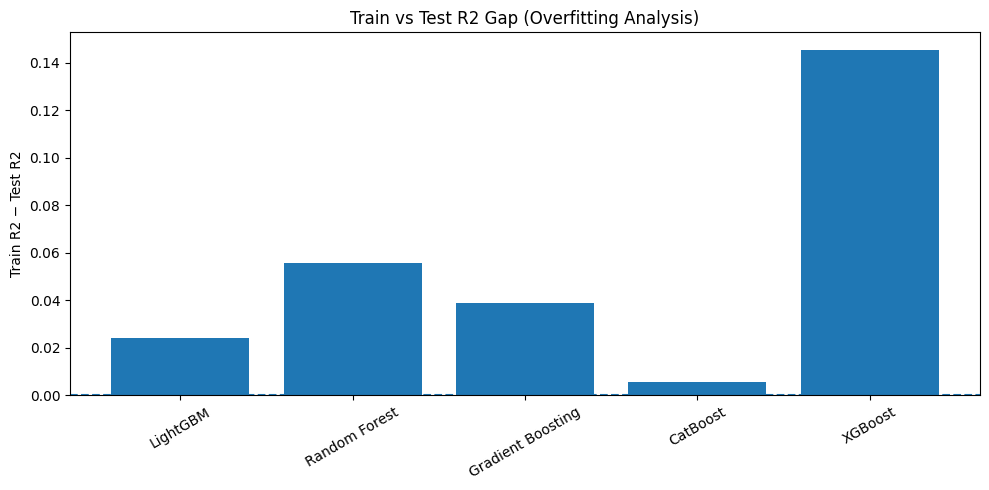

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.bar(
    final_df["Model"],
    final_df["final/train/r2"] - final_df["final/test/r2"]
)

plt.axhline(0, linestyle="--")
plt.ylabel("Train R2 − Test R2")
plt.title("Train vs Test R2 Gap (Overfitting Analysis)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

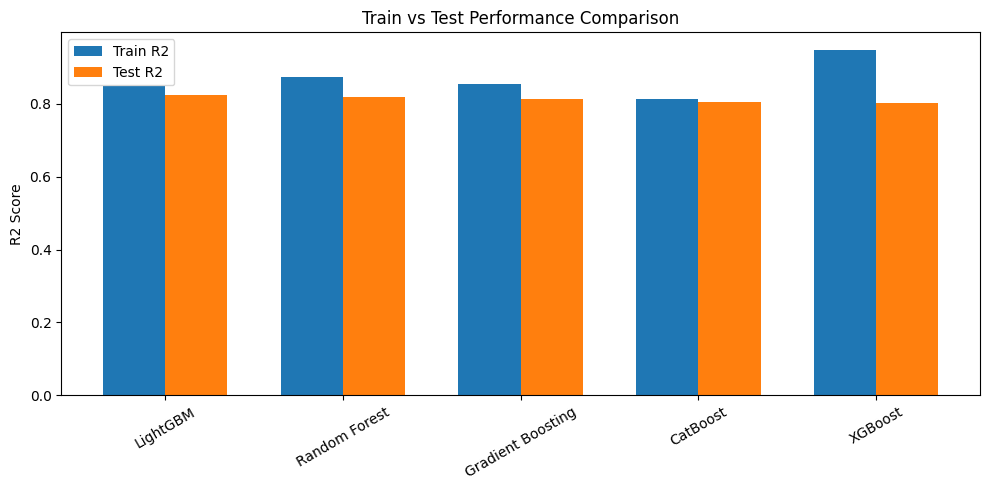

In [47]:
import numpy as np

x = np.arange(len(final_df))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, final_df["final/train/r2"], width, label="Train R2")
plt.bar(x + width/2, final_df["final/test/r2"], width, label="Test R2")

plt.xticks(x, final_df["Model"], rotation=30)
plt.ylabel("R2 Score")
plt.title("Train vs Test Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
final_df["Stability_Score"] = (
    final_df["cv/test/r2"] / (final_df["cv/test/r2_std"] + 1e-6)
)

final_df.sort_values("Stability_Score", ascending=False)

,Model,cv/train/r2,cv/test/r2,cv/train/mae,cv/test/mae,cv/train/rmse,cv/test/rmse,cv/test/r2_std,final/train/r2,final/test/r2,final/train/mae,final/test/mae,final/train/rmse,final/test/rmse,final/r2_gap,Stability_Score
0,LightGBM,0.851844,0.824046,0.309552,0.335396,0.384906,0.419423,0.001474,0.847811,0.823672,0.313583,0.339135,0.390114,0.421230,0.024139,558.713106
3,CatBoost,0.811620,0.806267,0.346579,0.351615,0.434025,0.440101,0.001651,0.811746,0.806047,0.346571,0.354806,0.433883,0.441782,0.005699,488.157196
1,Random Forest,0.874652,0.815964,0.280835,0.341461,0.354042,0.428941,0.002108,0.873243,0.817462,0.282824,0.343789,0.356029,0.428583,0.055781,386.884481
4,XGBoost,0.958906,0.803593,0.157252,0.351739,0.202716,0.443117,0.002698,0.948592,0.803012,0.177139,0.355076,0.226733,0.445225,0.145580,297.729034
2,Gradient Boosting,0.860081,0.814201,0.297343,0.344195,0.374049,0.430978,0.002933,0.853296,0.814319,0.304868,0.348112,0.383019,0.432257,0.038977,277.472537


In [49]:
final_df["CV_R2_Gap"] = (
    final_df["cv/train/r2"] - final_df["cv/test/r2"]
)

final_df.sort_values("CV_R2_Gap", ascending=True)

,Model,cv/train/r2,cv/test/r2,cv/train/mae,cv/test/mae,cv/train/rmse,cv/test/rmse,cv/test/r2_std,final/train/r2,final/test/r2,final/train/mae,final/test/mae,final/train/rmse,final/test/rmse,final/r2_gap,Stability_Score,CV_R2_Gap
3,CatBoost,0.811620,0.806267,0.346579,0.351615,0.434025,0.440101,0.001651,0.811746,0.806047,0.346571,0.354806,0.433883,0.441782,0.005699,488.157196,0.005352
0,LightGBM,0.851844,0.824046,0.309552,0.335396,0.384906,0.419423,0.001474,0.847811,0.823672,0.313583,0.339135,0.390114,0.421230,0.024139,558.713106,0.027798
2,Gradient Boosting,0.860081,0.814201,0.297343,0.344195,0.374049,0.430978,0.002933,0.853296,0.814319,0.304868,0.348112,0.383019,0.432257,0.038977,277.472537,0.045880
1,Random Forest,0.874652,0.815964,0.280835,0.341461,0.354042,0.428941,0.002108,0.873243,0.817462,0.282824,0.343789,0.356029,0.428583,0.055781,386.884481,0.058688
4,XGBoost,0.958906,0.803593,0.157252,0.351739,0.202716,0.443117,0.002698,0.948592,0.803012,0.177139,0.355076,0.226733,0.445225,0.145580,297.729034,0.155313


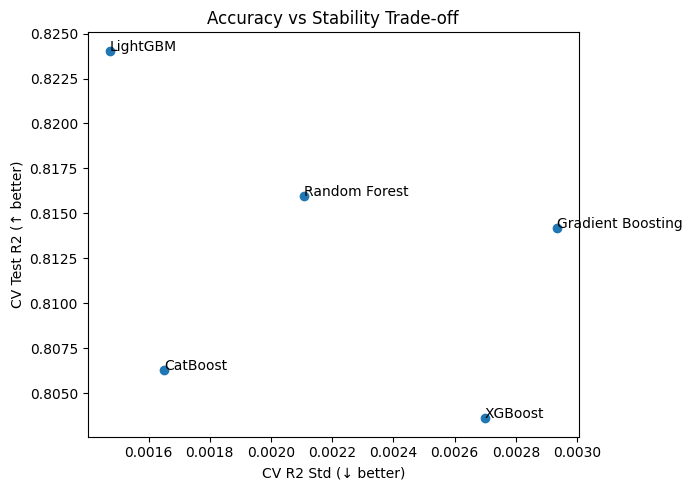

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.scatter(
    final_df["cv/test/r2_std"],
    final_df["cv/test/r2"]
)

for _, row in final_df.iterrows():
    plt.text(row["cv/test/r2_std"], row["cv/test/r2"], row["Model"])

plt.xlabel("CV R2 Std (↓ better)")
plt.ylabel("CV Test R2 (↑ better)")
plt.title("Accuracy vs Stability Trade-off")
plt.tight_layout()
plt.show()

In [51]:
rank_df = final_df.copy()

rank_df["R2_Rank"] = rank_df["cv/test/r2"].rank(ascending=False)
rank_df["RMSE_Rank"] = rank_df["cv/test/rmse"].rank()
rank_df["MAE_Rank"] = rank_df["cv/test/mae"].rank()

rank_df["Avg_Rank"] = rank_df[
    ["R2_Rank", "RMSE_Rank", "MAE_Rank"]
].mean(axis=1)

rank_df.sort_values("Avg_Rank")

,Model,cv/train/r2,cv/test/r2,cv/train/mae,cv/test/mae,cv/train/rmse,cv/test/rmse,cv/test/r2_std,final/train/r2,final/test/r2,...,final/test/mae,final/train/rmse,final/test/rmse,final/r2_gap,Stability_Score,CV_R2_Gap,R2_Rank,RMSE_Rank,MAE_Rank,Avg_Rank
0,LightGBM,0.851844,0.824046,0.309552,0.335396,0.384906,0.419423,0.001474,0.847811,0.823672,...,0.339135,0.390114,0.421230,0.024139,558.713106,0.027798,1.0,1.0,1.0,1.0
1,Random Forest,0.874652,0.815964,0.280835,0.341461,0.354042,0.428941,0.002108,0.873243,0.817462,...,0.343789,0.356029,0.428583,0.055781,386.884481,0.058688,2.0,2.0,2.0,2.0
2,Gradient Boosting,0.860081,0.814201,0.297343,0.344195,0.374049,0.430978,0.002933,0.853296,0.814319,...,0.348112,0.383019,0.432257,0.038977,277.472537,0.045880,3.0,3.0,3.0,3.0
3,CatBoost,0.811620,0.806267,0.346579,0.351615,0.434025,0.440101,0.001651,0.811746,0.806047,...,0.354806,0.433883,0.441782,0.005699,488.157196,0.005352,4.0,4.0,4.0,4.0
4,XGBoost,0.958906,0.803593,0.157252,0.351739,0.202716,0.443117,0.002698,0.948592,0.803012,...,0.355076,0.226733,0.445225,0.145580,297.729034,0.155313,5.0,5.0,5.0,5.0


In [52]:
model_family = {
    "Linear Regression": "Linear",
    "SVR": "Kernel",
    "Decision Tree": "Tree",
    "Random Forest": "Ensemble",
    "Extra Trees": "Ensemble",
    "Gradient Boosting": "Boosting",
    "XGBoost": "Boosting",
    "LightGBM": "Boosting",
    "CatBoost": "Boosting"
}

final_df["Family"] = final_df["Model"].map(model_family)

final_df.groupby("Family")[["cv/test/r2", "cv/test/r2_std"]].mean()

,cv/test/r2,cv/test/r2_std
Family,,
Boosting,0.812027,0.002189
Ensemble,0.815964,0.002108


In [53]:
final_df[
    [
        "Model",
        "cv/test/r2",
        "cv/test/r2_std",
        "CV_R2_Gap",
        "cv/test/rmse",
        "cv/test/mae"
    ]
].sort_values("cv/test/r2", ascending=False)

,Model,cv/test/r2,cv/test/r2_std,CV_R2_Gap,cv/test/rmse,cv/test/mae
0,LightGBM,0.824046,0.001474,0.027798,0.419423,0.335396
1,Random Forest,0.815964,0.002108,0.058688,0.428941,0.341461
2,Gradient Boosting,0.814201,0.002933,0.045880,0.430978,0.344195
3,CatBoost,0.806267,0.001651,0.005352,0.440101,0.351615
4,XGBoost,0.803593,0.002698,0.155313,0.443117,0.351739


In [54]:
final_df.to_csv(
    "model_analysis_cv_detailed.csv",
    index=False
)

In [55]:
df.to_csv(
    "food_delivery_interim.csv",
    index=False
)